In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=0,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.w2 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, )# bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'

schema_root = root+'schema2.txt'

relation_data = root+'skincare_mr.train'
dev_data = root+'skincare_mr.dev'
test_data = root+'skincare_mr.test'

# relation_data = root+'facial_r3_len80.train'
# dev_data = root+'facial_r3_len80.dev'
# test_data = root+'facial_r3_len80.test'



UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100     # original 100
BATCH_SIZE = 32

EMBEDDING_DIM = 40   # original 40
HIDDEN_DIM1 = 20     # original 20
HIDDEN_DIM2 = 16     # original 16
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 32        # original 6       

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
# criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 200
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

loss = 0
start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))


  0%|          | 1/200 [00:09<32:51,  9.91s/it]

epoch: 1 | ent loss 0.6394 | rel loss 0.0033 | total loss 0.6428
         | val ent loss 0.5213 | val rel loss 0.0041


  1%|          | 2/200 [00:20<33:41, 10.21s/it]

epoch: 2 | ent loss 0.3946 | rel loss 0.0068 | total loss 0.4013
         | val ent loss 0.4725 | val rel loss 0.0057


  2%|▏         | 3/200 [00:30<33:32, 10.22s/it]

epoch: 3 | ent loss 0.3608 | rel loss 0.0055 | total loss 0.3663
         | val ent loss 0.2977 | val rel loss 0.0054


  2%|▏         | 4/200 [00:41<33:48, 10.35s/it]

epoch: 4 | ent loss 0.3428 | rel loss 0.0088 | total loss 0.3515
         | val ent loss 0.3441 | val rel loss 0.0059


  2%|▎         | 5/200 [00:51<33:13, 10.22s/it]

epoch: 5 | ent loss 0.2258 | rel loss 0.0061 | total loss 0.2319
         | val ent loss 0.2511 | val rel loss 0.0034


  3%|▎         | 6/200 [01:01<33:17, 10.29s/it]

epoch: 6 | ent loss 0.1859 | rel loss 0.0071 | total loss 0.1930
         | val ent loss 0.1566 | val rel loss 0.0052


  4%|▎         | 7/200 [01:12<33:18, 10.35s/it]

epoch: 7 | ent loss 0.1818 | rel loss 0.0055 | total loss 0.1874
         | val ent loss 0.2045 | val rel loss 0.0079


  4%|▍         | 8/200 [01:22<33:05, 10.34s/it]

epoch: 8 | ent loss 0.1286 | rel loss 0.0055 | total loss 0.1341
         | val ent loss 0.1110 | val rel loss 0.0089


  4%|▍         | 9/200 [01:32<32:51, 10.32s/it]

epoch: 9 | ent loss 0.0957 | rel loss 0.0041 | total loss 0.0998
         | val ent loss 0.0512 | val rel loss 0.0049


  5%|▌         | 10/200 [01:43<32:44, 10.34s/it]

epoch: 10 | ent loss 0.1233 | rel loss 0.0047 | total loss 0.1281
          | val ent loss 0.0414 | val rel loss 0.0043


  6%|▌         | 11/200 [01:53<32:31, 10.32s/it]

epoch: 11 | ent loss 0.0601 | rel loss 0.0068 | total loss 0.0669
          | val ent loss 0.0537 | val rel loss 0.0078


  6%|▌         | 12/200 [02:03<32:19, 10.31s/it]

epoch: 12 | ent loss 0.0598 | rel loss 0.0023 | total loss 0.0621
          | val ent loss 0.0481 | val rel loss 0.0035


  6%|▋         | 13/200 [02:11<31:28, 10.10s/it]

epoch: 13 | ent loss 0.0479 | rel loss 0.0044 | total loss 0.0524
          | val ent loss 0.1016 | val rel loss 0.0042


  7%|▋         | 14/200 [02:20<31:05, 10.03s/it]

epoch: 14 | ent loss 0.0462 | rel loss 0.0047 | total loss 0.0509
          | val ent loss 0.1220 | val rel loss 0.0045


  8%|▊         | 15/200 [02:30<30:56, 10.04s/it]

epoch: 15 | ent loss 0.0611 | rel loss 0.0044 | total loss 0.0655
          | val ent loss 0.0638 | val rel loss 0.0023


  8%|▊         | 16/200 [02:40<30:48, 10.05s/it]

epoch: 16 | ent loss 0.0357 | rel loss 0.0024 | total loss 0.0380
          | val ent loss 0.0474 | val rel loss 0.0032


  8%|▊         | 17/200 [02:50<30:36, 10.03s/it]

epoch: 17 | ent loss 0.0303 | rel loss 0.0042 | total loss 0.0345
          | val ent loss 0.1043 | val rel loss 0.0020


  9%|▉         | 18/200 [03:00<30:21, 10.01s/it]

epoch: 18 | ent loss 0.0380 | rel loss 0.0031 | total loss 0.0412
          | val ent loss 0.0662 | val rel loss 0.0034


 10%|▉         | 19/200 [03:09<30:09, 10.00s/it]

epoch: 19 | ent loss 0.0297 | rel loss 0.0032 | total loss 0.0329
          | val ent loss 0.0558 | val rel loss 0.0023


 10%|█         | 20/200 [03:19<29:59, 10.00s/it]

epoch: 20 | ent loss 0.1184 | rel loss 0.0019 | total loss 0.1203
          | val ent loss 0.0507 | val rel loss 0.0020


 10%|█         | 21/200 [03:30<29:52, 10.01s/it]

epoch: 21 | ent loss 0.0472 | rel loss 0.0020 | total loss 0.0492
          | val ent loss 0.0833 | val rel loss 0.0012


 11%|█         | 22/200 [03:40<29:45, 10.03s/it]

epoch: 22 | ent loss 0.0281 | rel loss 0.0021 | total loss 0.0302
          | val ent loss 0.0713 | val rel loss 0.0029


 12%|█▏        | 23/200 [03:51<29:40, 10.06s/it]

epoch: 23 | ent loss 0.0088 | rel loss 0.0022 | total loss 0.0110
          | val ent loss 0.0131 | val rel loss 0.0042


 12%|█▏        | 24/200 [04:01<29:34, 10.08s/it]

epoch: 24 | ent loss 0.0224 | rel loss 0.0032 | total loss 0.0256
          | val ent loss 0.0548 | val rel loss 0.0030


 12%|█▎        | 25/200 [04:11<29:22, 10.07s/it]

epoch: 25 | ent loss 0.0388 | rel loss 0.0024 | total loss 0.0412
          | val ent loss 0.0384 | val rel loss 0.0009


 13%|█▎        | 26/200 [04:20<29:01, 10.01s/it]

epoch: 26 | ent loss 0.0321 | rel loss 0.0019 | total loss 0.0340
          | val ent loss 0.0947 | val rel loss 0.0032


 14%|█▎        | 27/200 [04:30<28:55, 10.03s/it]

epoch: 27 | ent loss 0.0100 | rel loss 0.0021 | total loss 0.0121
          | val ent loss 0.0196 | val rel loss 0.0029


 14%|█▍        | 28/200 [04:41<28:49, 10.06s/it]

epoch: 28 | ent loss 0.0142 | rel loss 0.0016 | total loss 0.0157
          | val ent loss 0.0681 | val rel loss 0.0045


 14%|█▍        | 29/200 [04:51<28:40, 10.06s/it]

epoch: 29 | ent loss 0.0353 | rel loss 0.0020 | total loss 0.0373
          | val ent loss 0.0439 | val rel loss 0.0022


 15%|█▌        | 30/200 [05:01<28:30, 10.06s/it]

epoch: 30 | ent loss 0.0367 | rel loss 0.0015 | total loss 0.0382
          | val ent loss 0.1255 | val rel loss 0.0030


 16%|█▌        | 31/200 [05:11<28:20, 10.06s/it]

epoch: 31 | ent loss 0.0138 | rel loss 0.0015 | total loss 0.0153
          | val ent loss 0.1446 | val rel loss 0.0019


 16%|█▌        | 32/200 [05:22<28:13, 10.08s/it]

epoch: 32 | ent loss 0.0130 | rel loss 0.0018 | total loss 0.0147
          | val ent loss 0.0191 | val rel loss 0.0011


 16%|█▋        | 33/200 [05:33<28:06, 10.10s/it]

epoch: 33 | ent loss 0.0533 | rel loss 0.0019 | total loss 0.0551
          | val ent loss 0.0939 | val rel loss 0.0006


 17%|█▋        | 34/200 [05:43<27:58, 10.11s/it]

epoch: 34 | ent loss 0.0091 | rel loss 0.0017 | total loss 0.0108
          | val ent loss 0.0065 | val rel loss 0.0016


 18%|█▊        | 35/200 [05:54<27:49, 10.12s/it]

epoch: 35 | ent loss 0.0105 | rel loss 0.0016 | total loss 0.0121
          | val ent loss 0.0816 | val rel loss 0.0017


 18%|█▊        | 36/200 [06:04<27:39, 10.12s/it]

epoch: 36 | ent loss 0.0299 | rel loss 0.0014 | total loss 0.0313
          | val ent loss 0.0480 | val rel loss 0.0013


 18%|█▊        | 37/200 [06:14<27:28, 10.11s/it]

epoch: 37 | ent loss 0.0199 | rel loss 0.0019 | total loss 0.0218
          | val ent loss 0.0729 | val rel loss 0.0014


 19%|█▉        | 38/200 [06:24<27:19, 10.12s/it]

epoch: 38 | ent loss 0.0147 | rel loss 0.0015 | total loss 0.0162
          | val ent loss 0.0366 | val rel loss 0.0013


 20%|█▉        | 39/200 [06:31<26:56, 10.04s/it]

epoch: 39 | ent loss 0.0218 | rel loss 0.0022 | total loss 0.0241
          | val ent loss 0.0165 | val rel loss 0.0045


 20%|██        | 40/200 [06:38<26:33,  9.96s/it]

epoch: 40 | ent loss 0.0063 | rel loss 0.0012 | total loss 0.0075
          | val ent loss 0.0463 | val rel loss 0.0018


 20%|██        | 41/200 [06:48<26:23,  9.96s/it]

epoch: 41 | ent loss 0.0279 | rel loss 0.0008 | total loss 0.0287
          | val ent loss 0.0598 | val rel loss 0.0015


 21%|██        | 42/200 [06:58<26:15,  9.97s/it]

epoch: 42 | ent loss 0.0160 | rel loss 0.0014 | total loss 0.0174
          | val ent loss 0.0501 | val rel loss 0.0025


 22%|██▏       | 43/200 [07:09<26:06,  9.98s/it]

epoch: 43 | ent loss 0.0211 | rel loss 0.0012 | total loss 0.0223
          | val ent loss 0.0980 | val rel loss 0.0024


 22%|██▏       | 44/200 [07:19<25:57,  9.98s/it]

epoch: 44 | ent loss 0.0300 | rel loss 0.0009 | total loss 0.0309
          | val ent loss 0.0780 | val rel loss 0.0010


 22%|██▎       | 45/200 [07:29<25:47,  9.98s/it]

epoch: 45 | ent loss 0.0099 | rel loss 0.0015 | total loss 0.0114
          | val ent loss 0.1030 | val rel loss 0.0031


 23%|██▎       | 46/200 [07:38<25:36,  9.98s/it]

epoch: 46 | ent loss 0.0056 | rel loss 0.0009 | total loss 0.0065
          | val ent loss 0.0037 | val rel loss 0.0011


 24%|██▎       | 47/200 [07:47<25:22,  9.95s/it]

epoch: 47 | ent loss 0.0276 | rel loss 0.0012 | total loss 0.0288
          | val ent loss 0.0482 | val rel loss 0.0035


 24%|██▍       | 48/200 [07:57<25:10,  9.94s/it]

epoch: 48 | ent loss 0.0126 | rel loss 0.0017 | total loss 0.0144
          | val ent loss 0.0276 | val rel loss 0.0010


 24%|██▍       | 49/200 [08:07<25:01,  9.94s/it]

epoch: 49 | ent loss 0.0118 | rel loss 0.0011 | total loss 0.0129
          | val ent loss 0.0803 | val rel loss 0.0026


 25%|██▌       | 50/200 [08:17<24:51,  9.94s/it]

epoch: 50 | ent loss 0.0162 | rel loss 0.0013 | total loss 0.0175
          | val ent loss 0.0439 | val rel loss 0.0019


 26%|██▌       | 51/200 [08:27<24:41,  9.94s/it]

epoch: 51 | ent loss 0.0147 | rel loss 0.0025 | total loss 0.0172
          | val ent loss 0.0455 | val rel loss 0.0019


 26%|██▌       | 52/200 [08:36<24:31,  9.94s/it]

epoch: 52 | ent loss 0.0127 | rel loss 0.0013 | total loss 0.0139
          | val ent loss 0.1206 | val rel loss 0.0021


 26%|██▋       | 53/200 [08:43<24:12,  9.88s/it]

epoch: 53 | ent loss 0.0289 | rel loss 0.0009 | total loss 0.0298
          | val ent loss 0.0554 | val rel loss 0.0017


 27%|██▋       | 54/200 [08:50<23:53,  9.82s/it]

epoch: 54 | ent loss 0.0391 | rel loss 0.0026 | total loss 0.0418
          | val ent loss 0.0640 | val rel loss 0.0032


 28%|██▊       | 55/200 [09:00<23:44,  9.83s/it]

epoch: 55 | ent loss 0.0095 | rel loss 0.0011 | total loss 0.0106
          | val ent loss 0.0649 | val rel loss 0.0021


 28%|██▊       | 56/200 [09:11<23:37,  9.85s/it]

epoch: 56 | ent loss 0.0376 | rel loss 0.0012 | total loss 0.0389
          | val ent loss 0.0407 | val rel loss 0.0012


 28%|██▊       | 57/200 [09:22<23:30,  9.86s/it]

epoch: 57 | ent loss 0.0305 | rel loss 0.0019 | total loss 0.0325
          | val ent loss 0.0602 | val rel loss 0.0021


 29%|██▉       | 58/200 [09:32<23:22,  9.88s/it]

epoch: 58 | ent loss 0.0221 | rel loss 0.0014 | total loss 0.0234
          | val ent loss 0.0048 | val rel loss 0.0017


 30%|██▉       | 59/200 [09:43<23:14,  9.89s/it]

epoch: 59 | ent loss 0.0108 | rel loss 0.0024 | total loss 0.0132
          | val ent loss 0.2530 | val rel loss 0.0022


 30%|███       | 60/200 [09:54<23:06,  9.91s/it]

epoch: 60 | ent loss 0.0164 | rel loss 0.0014 | total loss 0.0178
          | val ent loss 0.1923 | val rel loss 0.0020


 30%|███       | 61/200 [10:05<22:58,  9.92s/it]

epoch: 61 | ent loss 0.0073 | rel loss 0.0016 | total loss 0.0089
          | val ent loss 0.0060 | val rel loss 0.0010


 31%|███       | 62/200 [10:16<22:51,  9.94s/it]

epoch: 62 | ent loss 0.0161 | rel loss 0.0011 | total loss 0.0172
          | val ent loss 0.0382 | val rel loss 0.0008


 32%|███▏      | 63/200 [10:26<22:42,  9.95s/it]

epoch: 63 | ent loss 0.0125 | rel loss 0.0015 | total loss 0.0140
          | val ent loss 0.0272 | val rel loss 0.0018


 32%|███▏      | 64/200 [10:37<22:34,  9.96s/it]

epoch: 64 | ent loss 0.0036 | rel loss 0.0013 | total loss 0.0049
          | val ent loss 0.0528 | val rel loss 0.0028


 32%|███▎      | 65/200 [10:48<22:26,  9.97s/it]

epoch: 65 | ent loss 0.0272 | rel loss 0.0025 | total loss 0.0297
          | val ent loss 0.0498 | val rel loss 0.0022


 33%|███▎      | 66/200 [10:58<22:17,  9.98s/it]

epoch: 66 | ent loss 0.0169 | rel loss 0.0015 | total loss 0.0184
          | val ent loss 0.2050 | val rel loss 0.0008


 34%|███▎      | 67/200 [11:09<22:09, 10.00s/it]

epoch: 67 | ent loss 0.0505 | rel loss 0.0013 | total loss 0.0518
          | val ent loss 0.0481 | val rel loss 0.0027


 34%|███▍      | 68/200 [11:20<22:00, 10.00s/it]

epoch: 68 | ent loss 0.0125 | rel loss 0.0015 | total loss 0.0140
          | val ent loss 0.0131 | val rel loss 0.0046


 34%|███▍      | 69/200 [11:31<21:51, 10.01s/it]

epoch: 69 | ent loss 0.0206 | rel loss 0.0015 | total loss 0.0222
          | val ent loss 0.0612 | val rel loss 0.0027


 35%|███▌      | 70/200 [11:41<21:43, 10.03s/it]

epoch: 70 | ent loss 0.0248 | rel loss 0.0011 | total loss 0.0259
          | val ent loss 0.1657 | val rel loss 0.0036


 36%|███▌      | 71/200 [11:52<21:34, 10.03s/it]

epoch: 71 | ent loss 0.0104 | rel loss 0.0013 | total loss 0.0117
          | val ent loss 0.0015 | val rel loss 0.0005


 36%|███▌      | 72/200 [12:03<21:25, 10.04s/it]

epoch: 72 | ent loss 0.0040 | rel loss 0.0011 | total loss 0.0052
          | val ent loss 0.0125 | val rel loss 0.0012


 36%|███▋      | 73/200 [12:13<21:16, 10.05s/it]

epoch: 73 | ent loss 0.0049 | rel loss 0.0015 | total loss 0.0064
          | val ent loss 0.1081 | val rel loss 0.0014


 37%|███▋      | 74/200 [12:24<21:07, 10.06s/it]

epoch: 74 | ent loss 0.0060 | rel loss 0.0013 | total loss 0.0074
          | val ent loss 0.0551 | val rel loss 0.0018


 38%|███▊      | 75/200 [12:34<20:58, 10.06s/it]

epoch: 75 | ent loss 0.0255 | rel loss 0.0010 | total loss 0.0265
          | val ent loss 0.1123 | val rel loss 0.0033


 38%|███▊      | 76/200 [12:45<20:48, 10.07s/it]

epoch: 76 | ent loss 0.0223 | rel loss 0.0024 | total loss 0.0248
          | val ent loss 0.0495 | val rel loss 0.0068


 38%|███▊      | 77/200 [12:55<20:39, 10.08s/it]

epoch: 77 | ent loss 0.0457 | rel loss 0.0020 | total loss 0.0476
          | val ent loss 0.1058 | val rel loss 0.0006


 39%|███▉      | 78/200 [13:04<20:26, 10.06s/it]

epoch: 78 | ent loss 0.0534 | rel loss 0.0010 | total loss 0.0545
          | val ent loss 0.0488 | val rel loss 0.0018


 40%|███▉      | 79/200 [13:11<20:11, 10.02s/it]

epoch: 79 | ent loss 0.0138 | rel loss 0.0015 | total loss 0.0153
          | val ent loss 0.1178 | val rel loss 0.0014


 40%|████      | 80/200 [13:21<20:02, 10.02s/it]

epoch: 80 | ent loss 0.0076 | rel loss 0.0008 | total loss 0.0084
          | val ent loss 0.1029 | val rel loss 0.0018


 40%|████      | 81/200 [13:32<19:53, 10.03s/it]

epoch: 81 | ent loss 0.0136 | rel loss 0.0011 | total loss 0.0147
          | val ent loss 0.1193 | val rel loss 0.0023


 41%|████      | 82/200 [13:43<19:44, 10.04s/it]

epoch: 82 | ent loss 0.0043 | rel loss 0.0012 | total loss 0.0055
          | val ent loss 0.0204 | val rel loss 0.0003


 42%|████▏     | 83/200 [13:54<19:35, 10.05s/it]

epoch: 83 | ent loss 0.0097 | rel loss 0.0014 | total loss 0.0111
          | val ent loss 0.0048 | val rel loss 0.0005


 42%|████▏     | 84/200 [14:04<19:26, 10.06s/it]

epoch: 84 | ent loss 0.0197 | rel loss 0.0014 | total loss 0.0211
          | val ent loss 0.0209 | val rel loss 0.0011


 42%|████▎     | 85/200 [14:15<19:17, 10.06s/it]

epoch: 85 | ent loss 0.0298 | rel loss 0.0008 | total loss 0.0305
          | val ent loss 0.0494 | val rel loss 0.0013


 43%|████▎     | 86/200 [14:26<19:08, 10.07s/it]

epoch: 86 | ent loss 0.0146 | rel loss 0.0009 | total loss 0.0155
          | val ent loss 0.0044 | val rel loss 0.0013


 44%|████▎     | 87/200 [14:36<18:59, 10.08s/it]

epoch: 87 | ent loss 0.0031 | rel loss 0.0008 | total loss 0.0039
          | val ent loss 0.1423 | val rel loss 0.0012


 44%|████▍     | 88/200 [14:47<18:49, 10.09s/it]

epoch: 88 | ent loss 0.0132 | rel loss 0.0011 | total loss 0.0143
          | val ent loss 0.2523 | val rel loss 0.0028


 44%|████▍     | 89/200 [14:58<18:40, 10.10s/it]

epoch: 89 | ent loss 0.0219 | rel loss 0.0009 | total loss 0.0228
          | val ent loss 0.0960 | val rel loss 0.0023


 45%|████▌     | 90/200 [15:09<18:31, 10.10s/it]

epoch: 90 | ent loss 0.0097 | rel loss 0.0013 | total loss 0.0109
          | val ent loss 0.0596 | val rel loss 0.0014


 46%|████▌     | 91/200 [15:19<18:21, 10.10s/it]

epoch: 91 | ent loss 0.0072 | rel loss 0.0011 | total loss 0.0083
          | val ent loss 0.0849 | val rel loss 0.0028


 46%|████▌     | 92/200 [15:30<18:11, 10.11s/it]

epoch: 92 | ent loss 0.0276 | rel loss 0.0009 | total loss 0.0285
          | val ent loss 0.0421 | val rel loss 0.0009


 46%|████▋     | 93/200 [15:40<18:02, 10.12s/it]

epoch: 93 | ent loss 0.0025 | rel loss 0.0010 | total loss 0.0036
          | val ent loss 0.1532 | val rel loss 0.0014


 47%|████▋     | 94/200 [15:51<17:52, 10.12s/it]

epoch: 94 | ent loss 0.0140 | rel loss 0.0010 | total loss 0.0150
          | val ent loss 0.1148 | val rel loss 0.0011


 48%|████▊     | 95/200 [16:01<17:43, 10.13s/it]

epoch: 95 | ent loss 0.0091 | rel loss 0.0010 | total loss 0.0101
          | val ent loss 0.0080 | val rel loss 0.0015


 48%|████▊     | 96/200 [16:12<17:33, 10.13s/it]

epoch: 96 | ent loss 0.0440 | rel loss 0.0011 | total loss 0.0450
          | val ent loss 0.0312 | val rel loss 0.0010


 48%|████▊     | 97/200 [16:23<17:24, 10.14s/it]

epoch: 97 | ent loss 0.0199 | rel loss 0.0010 | total loss 0.0209
          | val ent loss 0.0259 | val rel loss 0.0021


 49%|████▉     | 98/200 [16:33<17:14, 10.14s/it]

epoch: 98 | ent loss 0.0186 | rel loss 0.0011 | total loss 0.0197
          | val ent loss 0.0145 | val rel loss 0.0014


 50%|████▉     | 99/200 [16:44<17:04, 10.15s/it]

epoch: 99 | ent loss 0.0103 | rel loss 0.0010 | total loss 0.0113
          | val ent loss 0.0356 | val rel loss 0.0020


 50%|█████     | 100/200 [16:55<16:55, 10.16s/it]

epoch: 100 | ent loss 0.0089 | rel loss 0.0010 | total loss 0.0099
           | val ent loss 0.0828 | val rel loss 0.0011


 50%|█████     | 101/200 [17:06<16:46, 10.16s/it]

epoch: 101 | ent loss 0.0039 | rel loss 0.0010 | total loss 0.0049
           | val ent loss 0.0353 | val rel loss 0.0012


 51%|█████     | 102/200 [17:17<16:36, 10.17s/it]

epoch: 102 | ent loss 0.0204 | rel loss 0.0009 | total loss 0.0213
           | val ent loss 0.0038 | val rel loss 0.0013


 52%|█████▏    | 103/200 [17:28<16:27, 10.18s/it]

epoch: 103 | ent loss 0.0161 | rel loss 0.0011 | total loss 0.0172
           | val ent loss 0.1276 | val rel loss 0.0021


 52%|█████▏    | 104/200 [17:39<16:17, 10.19s/it]

epoch: 104 | ent loss 0.0043 | rel loss 0.0015 | total loss 0.0058
           | val ent loss 0.0523 | val rel loss 0.0015


 52%|█████▎    | 105/200 [17:49<16:07, 10.19s/it]

epoch: 105 | ent loss 0.0154 | rel loss 0.0014 | total loss 0.0167
           | val ent loss 0.0096 | val rel loss 0.0010


 53%|█████▎    | 106/200 [17:59<15:57, 10.18s/it]

epoch: 106 | ent loss 0.0181 | rel loss 0.0013 | total loss 0.0194
           | val ent loss 0.0916 | val rel loss 0.0022


 54%|█████▎    | 107/200 [18:10<15:47, 10.19s/it]

epoch: 107 | ent loss 0.0095 | rel loss 0.0016 | total loss 0.0111
           | val ent loss 0.1096 | val rel loss 0.0007


 54%|█████▍    | 108/200 [18:21<15:38, 10.20s/it]

epoch: 108 | ent loss 0.0052 | rel loss 0.0008 | total loss 0.0061
           | val ent loss 0.0668 | val rel loss 0.0008


 55%|█████▍    | 109/200 [18:32<15:28, 10.20s/it]

epoch: 109 | ent loss 0.0036 | rel loss 0.0006 | total loss 0.0043
           | val ent loss 0.0546 | val rel loss 0.0012


 55%|█████▌    | 110/200 [18:42<15:18, 10.21s/it]

epoch: 110 | ent loss 0.0084 | rel loss 0.0011 | total loss 0.0095
           | val ent loss 0.2247 | val rel loss 0.0009


 56%|█████▌    | 111/200 [18:53<15:08, 10.21s/it]

epoch: 111 | ent loss 0.0033 | rel loss 0.0009 | total loss 0.0041
           | val ent loss 0.0750 | val rel loss 0.0015


 56%|█████▌    | 112/200 [19:04<14:59, 10.22s/it]

epoch: 112 | ent loss 0.0304 | rel loss 0.0012 | total loss 0.0316
           | val ent loss 0.1465 | val rel loss 0.0024


 56%|█████▋    | 113/200 [19:15<14:49, 10.22s/it]

epoch: 113 | ent loss 0.0145 | rel loss 0.0009 | total loss 0.0154
           | val ent loss 0.0099 | val rel loss 0.0004


 57%|█████▋    | 114/200 [19:26<14:39, 10.23s/it]

epoch: 114 | ent loss 0.0226 | rel loss 0.0011 | total loss 0.0237
           | val ent loss 0.0449 | val rel loss 0.0013


 57%|█████▊    | 115/200 [19:37<14:30, 10.24s/it]

epoch: 115 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
           | val ent loss 0.0247 | val rel loss 0.0039


 58%|█████▊    | 116/200 [19:48<14:20, 10.24s/it]

epoch: 116 | ent loss 0.0063 | rel loss 0.0007 | total loss 0.0070
           | val ent loss 0.1075 | val rel loss 0.0006


 58%|█████▊    | 117/200 [19:58<14:10, 10.25s/it]

epoch: 117 | ent loss 0.0143 | rel loss 0.0012 | total loss 0.0155
           | val ent loss 0.0225 | val rel loss 0.0011


 59%|█████▉    | 118/200 [20:09<14:00, 10.25s/it]

epoch: 118 | ent loss 0.0093 | rel loss 0.0007 | total loss 0.0100
           | val ent loss 0.1595 | val rel loss 0.0013


 60%|█████▉    | 119/200 [20:20<13:50, 10.26s/it]

epoch: 119 | ent loss 0.0020 | rel loss 0.0012 | total loss 0.0031
           | val ent loss 0.0974 | val rel loss 0.0015


 60%|██████    | 120/200 [20:31<13:41, 10.26s/it]

epoch: 120 | ent loss 0.0041 | rel loss 0.0009 | total loss 0.0049
           | val ent loss 0.0310 | val rel loss 0.0013


 60%|██████    | 121/200 [20:42<13:31, 10.27s/it]

epoch: 121 | ent loss 0.0035 | rel loss 0.0009 | total loss 0.0044
           | val ent loss 0.0629 | val rel loss 0.0014


 61%|██████    | 122/200 [20:53<13:21, 10.27s/it]

epoch: 122 | ent loss 0.0025 | rel loss 0.0011 | total loss 0.0036
           | val ent loss 0.0225 | val rel loss 0.0009


 62%|██████▏   | 123/200 [21:04<13:11, 10.28s/it]

epoch: 123 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0030
           | val ent loss 0.1735 | val rel loss 0.0018


 62%|██████▏   | 124/200 [21:15<13:01, 10.29s/it]

epoch: 124 | ent loss 0.0024 | rel loss 0.0007 | total loss 0.0030
           | val ent loss 0.0033 | val rel loss 0.0013


 62%|██████▎   | 125/200 [21:26<12:51, 10.29s/it]

epoch: 125 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0299 | val rel loss 0.0011


 63%|██████▎   | 126/200 [21:36<12:41, 10.29s/it]

epoch: 126 | ent loss 0.0113 | rel loss 0.0010 | total loss 0.0123
           | val ent loss 0.0066 | val rel loss 0.0005


 64%|██████▎   | 127/200 [21:47<12:31, 10.29s/it]

epoch: 127 | ent loss 0.0035 | rel loss 0.0009 | total loss 0.0044
           | val ent loss 0.0020 | val rel loss 0.0012


 64%|██████▍   | 128/200 [21:58<12:21, 10.30s/it]

epoch: 128 | ent loss 0.0045 | rel loss 0.0009 | total loss 0.0053
           | val ent loss 0.1006 | val rel loss 0.0008


 64%|██████▍   | 129/200 [22:09<12:11, 10.30s/it]

epoch: 129 | ent loss 0.0255 | rel loss 0.0009 | total loss 0.0264
           | val ent loss 0.0830 | val rel loss 0.0010


 65%|██████▌   | 130/200 [22:20<12:01, 10.31s/it]

epoch: 130 | ent loss 0.0037 | rel loss 0.0008 | total loss 0.0045
           | val ent loss 0.0724 | val rel loss 0.0022


 66%|██████▌   | 131/200 [22:30<11:51, 10.31s/it]

epoch: 131 | ent loss 0.0071 | rel loss 0.0008 | total loss 0.0079
           | val ent loss 0.0667 | val rel loss 0.0015


 66%|██████▌   | 132/200 [22:41<11:41, 10.32s/it]

epoch: 132 | ent loss 0.0223 | rel loss 0.0012 | total loss 0.0235
           | val ent loss 0.2508 | val rel loss 0.0038


 66%|██████▋   | 133/200 [22:52<11:31, 10.32s/it]

epoch: 133 | ent loss 0.0048 | rel loss 0.0007 | total loss 0.0055
           | val ent loss 0.0357 | val rel loss 0.0009


 67%|██████▋   | 134/200 [23:03<11:21, 10.32s/it]

epoch: 134 | ent loss 0.0024 | rel loss 0.0007 | total loss 0.0031
           | val ent loss 0.0780 | val rel loss 0.0019


 68%|██████▊   | 135/200 [23:14<11:11, 10.33s/it]

epoch: 135 | ent loss 0.0029 | rel loss 0.0010 | total loss 0.0039
           | val ent loss 0.1308 | val rel loss 0.0008


 68%|██████▊   | 136/200 [23:24<11:01, 10.33s/it]

epoch: 136 | ent loss 0.0141 | rel loss 0.0008 | total loss 0.0149
           | val ent loss 0.0858 | val rel loss 0.0034


 68%|██████▊   | 137/200 [23:35<10:50, 10.33s/it]

epoch: 137 | ent loss 0.0039 | rel loss 0.0010 | total loss 0.0049
           | val ent loss 0.0833 | val rel loss 0.0020


 69%|██████▉   | 138/200 [23:46<10:40, 10.34s/it]

epoch: 138 | ent loss 0.0071 | rel loss 0.0014 | total loss 0.0085
           | val ent loss 0.1008 | val rel loss 0.0014


 70%|██████▉   | 139/200 [23:56<10:30, 10.34s/it]

epoch: 139 | ent loss 0.0062 | rel loss 0.0008 | total loss 0.0070
           | val ent loss 0.0685 | val rel loss 0.0015


 70%|███████   | 140/200 [24:07<10:20, 10.34s/it]

epoch: 140 | ent loss 0.0037 | rel loss 0.0010 | total loss 0.0047
           | val ent loss 0.0013 | val rel loss 0.0008


 70%|███████   | 141/200 [24:18<10:10, 10.34s/it]

epoch: 141 | ent loss 0.0149 | rel loss 0.0009 | total loss 0.0158
           | val ent loss 0.1074 | val rel loss 0.0025


 71%|███████   | 142/200 [24:29<10:00, 10.35s/it]

epoch: 142 | ent loss 0.0197 | rel loss 0.0012 | total loss 0.0209
           | val ent loss 0.0380 | val rel loss 0.0014


 72%|███████▏  | 143/200 [24:40<09:49, 10.35s/it]

epoch: 143 | ent loss 0.0044 | rel loss 0.0009 | total loss 0.0053
           | val ent loss 0.0722 | val rel loss 0.0010


 72%|███████▏  | 144/200 [24:50<09:39, 10.35s/it]

epoch: 144 | ent loss 0.0041 | rel loss 0.0010 | total loss 0.0052
           | val ent loss 0.1270 | val rel loss 0.0013


 72%|███████▎  | 145/200 [25:01<09:29, 10.35s/it]

epoch: 145 | ent loss 0.0353 | rel loss 0.0021 | total loss 0.0374
           | val ent loss 0.1172 | val rel loss 0.0016


 73%|███████▎  | 146/200 [25:11<09:19, 10.35s/it]

epoch: 146 | ent loss 0.0158 | rel loss 0.0012 | total loss 0.0171
           | val ent loss 0.0896 | val rel loss 0.0048


 74%|███████▎  | 147/200 [25:22<09:08, 10.36s/it]

epoch: 147 | ent loss 0.0054 | rel loss 0.0009 | total loss 0.0063
           | val ent loss 0.0436 | val rel loss 0.0025


 74%|███████▍  | 148/200 [25:33<08:58, 10.36s/it]

epoch: 148 | ent loss 0.0038 | rel loss 0.0006 | total loss 0.0044
           | val ent loss 0.0586 | val rel loss 0.0009


 74%|███████▍  | 149/200 [25:43<08:48, 10.36s/it]

epoch: 149 | ent loss 0.0045 | rel loss 0.0006 | total loss 0.0051
           | val ent loss 0.0937 | val rel loss 0.0005


 75%|███████▌  | 150/200 [25:54<08:38, 10.36s/it]

epoch: 150 | ent loss 0.0048 | rel loss 0.0006 | total loss 0.0054
           | val ent loss 0.0017 | val rel loss 0.0009


 76%|███████▌  | 151/200 [26:05<08:27, 10.36s/it]

epoch: 151 | ent loss 0.0122 | rel loss 0.0009 | total loss 0.0131
           | val ent loss 0.1186 | val rel loss 0.0011


 76%|███████▌  | 152/200 [26:15<08:17, 10.37s/it]

epoch: 152 | ent loss 0.0032 | rel loss 0.0007 | total loss 0.0039
           | val ent loss 0.0036 | val rel loss 0.0010


 76%|███████▋  | 153/200 [26:26<08:07, 10.37s/it]

epoch: 153 | ent loss 0.0101 | rel loss 0.0009 | total loss 0.0110
           | val ent loss 0.0022 | val rel loss 0.0039


 77%|███████▋  | 154/200 [26:36<07:56, 10.37s/it]

epoch: 154 | ent loss 0.0245 | rel loss 0.0011 | total loss 0.0255
           | val ent loss 0.0303 | val rel loss 0.0014


 78%|███████▊  | 155/200 [26:47<07:46, 10.37s/it]

epoch: 155 | ent loss 0.0283 | rel loss 0.0010 | total loss 0.0293
           | val ent loss 0.0555 | val rel loss 0.0029


 78%|███████▊  | 156/200 [26:57<07:36, 10.37s/it]

epoch: 156 | ent loss 0.0023 | rel loss 0.0010 | total loss 0.0032
           | val ent loss 0.0119 | val rel loss 0.0035


 78%|███████▊  | 157/200 [27:08<07:25, 10.37s/it]

epoch: 157 | ent loss 0.0139 | rel loss 0.0010 | total loss 0.0149
           | val ent loss 0.0383 | val rel loss 0.0018


 79%|███████▉  | 158/200 [27:18<07:15, 10.37s/it]

epoch: 158 | ent loss 0.0082 | rel loss 0.0007 | total loss 0.0089
           | val ent loss 0.0048 | val rel loss 0.0009


 80%|███████▉  | 159/200 [27:28<07:05, 10.37s/it]

epoch: 159 | ent loss 0.0018 | rel loss 0.0007 | total loss 0.0025
           | val ent loss 0.0015 | val rel loss 0.0008


 80%|████████  | 160/200 [27:39<06:54, 10.37s/it]

epoch: 160 | ent loss 0.0034 | rel loss 0.0007 | total loss 0.0042
           | val ent loss 0.1484 | val rel loss 0.0008


 80%|████████  | 161/200 [27:49<06:44, 10.37s/it]

epoch: 161 | ent loss 0.0143 | rel loss 0.0011 | total loss 0.0153
           | val ent loss 0.0147 | val rel loss 0.0013


 81%|████████  | 162/200 [28:00<06:34, 10.37s/it]

epoch: 162 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0030
           | val ent loss 0.0935 | val rel loss 0.0015


 82%|████████▏ | 163/200 [28:10<06:23, 10.37s/it]

epoch: 163 | ent loss 0.0383 | rel loss 0.0010 | total loss 0.0394
           | val ent loss 0.0864 | val rel loss 0.0012


 82%|████████▏ | 164/200 [28:21<06:13, 10.37s/it]

epoch: 164 | ent loss 0.0089 | rel loss 0.0006 | total loss 0.0095
           | val ent loss 0.0861 | val rel loss 0.0016


 82%|████████▎ | 165/200 [28:31<06:03, 10.37s/it]

epoch: 165 | ent loss 0.0159 | rel loss 0.0011 | total loss 0.0170
           | val ent loss 0.2080 | val rel loss 0.0009


 83%|████████▎ | 166/200 [28:42<05:52, 10.37s/it]

epoch: 166 | ent loss 0.0044 | rel loss 0.0010 | total loss 0.0054
           | val ent loss 0.1150 | val rel loss 0.0025


 84%|████████▎ | 167/200 [28:52<05:42, 10.37s/it]

epoch: 167 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
           | val ent loss 0.1172 | val rel loss 0.0017


 84%|████████▍ | 168/200 [29:02<05:31, 10.37s/it]

epoch: 168 | ent loss 0.0035 | rel loss 0.0011 | total loss 0.0047
           | val ent loss 0.1114 | val rel loss 0.0016


 84%|████████▍ | 169/200 [29:13<05:21, 10.38s/it]

epoch: 169 | ent loss 0.0180 | rel loss 0.0010 | total loss 0.0190
           | val ent loss 0.0572 | val rel loss 0.0040


 85%|████████▌ | 170/200 [29:23<05:11, 10.37s/it]

epoch: 170 | ent loss 0.0015 | rel loss 0.0008 | total loss 0.0023
           | val ent loss 0.0467 | val rel loss 0.0018


 86%|████████▌ | 171/200 [29:34<05:00, 10.37s/it]

epoch: 171 | ent loss 0.0038 | rel loss 0.0008 | total loss 0.0046
           | val ent loss 0.0239 | val rel loss 0.0021


 86%|████████▌ | 172/200 [29:44<04:50, 10.38s/it]

epoch: 172 | ent loss 0.0057 | rel loss 0.0010 | total loss 0.0067
           | val ent loss 0.0014 | val rel loss 0.0010


 86%|████████▋ | 173/200 [29:54<04:40, 10.37s/it]

epoch: 173 | ent loss 0.0182 | rel loss 0.0008 | total loss 0.0190
           | val ent loss 0.2672 | val rel loss 0.0006


 87%|████████▋ | 174/200 [30:05<04:29, 10.38s/it]

epoch: 174 | ent loss 0.0042 | rel loss 0.0008 | total loss 0.0050
           | val ent loss 0.1746 | val rel loss 0.0032


 88%|████████▊ | 175/200 [30:16<04:19, 10.38s/it]

epoch: 175 | ent loss 0.0024 | rel loss 0.0019 | total loss 0.0043
           | val ent loss 0.0971 | val rel loss 0.0023


 88%|████████▊ | 176/200 [30:27<04:09, 10.38s/it]

epoch: 176 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0644 | val rel loss 0.0034


 88%|████████▊ | 177/200 [30:37<03:58, 10.38s/it]

epoch: 177 | ent loss 0.0055 | rel loss 0.0011 | total loss 0.0066
           | val ent loss 0.0668 | val rel loss 0.0019


 89%|████████▉ | 178/200 [30:48<03:48, 10.38s/it]

epoch: 178 | ent loss 0.0015 | rel loss 0.0008 | total loss 0.0023
           | val ent loss 0.0519 | val rel loss 0.0008


 90%|████████▉ | 179/200 [30:59<03:38, 10.39s/it]

epoch: 179 | ent loss 0.0418 | rel loss 0.0016 | total loss 0.0434
           | val ent loss 0.1003 | val rel loss 0.0012


 90%|█████████ | 180/200 [31:09<03:27, 10.39s/it]

epoch: 180 | ent loss 0.0085 | rel loss 0.0009 | total loss 0.0095
           | val ent loss 0.0921 | val rel loss 0.0017


 90%|█████████ | 181/200 [31:19<03:17, 10.39s/it]

epoch: 181 | ent loss 0.0151 | rel loss 0.0008 | total loss 0.0159
           | val ent loss 0.1532 | val rel loss 0.0013


 91%|█████████ | 182/200 [31:30<03:06, 10.39s/it]

epoch: 182 | ent loss 0.0204 | rel loss 0.0018 | total loss 0.0222
           | val ent loss 0.1026 | val rel loss 0.0009


 92%|█████████▏| 183/200 [31:41<02:56, 10.39s/it]

epoch: 183 | ent loss 0.0109 | rel loss 0.0013 | total loss 0.0122
           | val ent loss 0.0241 | val rel loss 0.0016


 92%|█████████▏| 184/200 [31:51<02:46, 10.39s/it]

epoch: 184 | ent loss 0.0108 | rel loss 0.0008 | total loss 0.0116
           | val ent loss 0.0454 | val rel loss 0.0060


 92%|█████████▎| 185/200 [32:02<02:35, 10.39s/it]

epoch: 185 | ent loss 0.0204 | rel loss 0.0019 | total loss 0.0223
           | val ent loss 0.0045 | val rel loss 0.0007


 93%|█████████▎| 186/200 [32:13<02:25, 10.39s/it]

epoch: 186 | ent loss 0.0039 | rel loss 0.0009 | total loss 0.0048
           | val ent loss 0.1234 | val rel loss 0.0013


 94%|█████████▎| 187/200 [32:23<02:15, 10.40s/it]

epoch: 187 | ent loss 0.0152 | rel loss 0.0007 | total loss 0.0159
           | val ent loss 0.0605 | val rel loss 0.0012


 94%|█████████▍| 188/200 [32:34<02:04, 10.40s/it]

epoch: 188 | ent loss 0.0290 | rel loss 0.0009 | total loss 0.0299
           | val ent loss 0.0500 | val rel loss 0.0007


 94%|█████████▍| 189/200 [32:45<01:54, 10.40s/it]

epoch: 189 | ent loss 0.0378 | rel loss 0.0008 | total loss 0.0386
           | val ent loss 0.1317 | val rel loss 0.0018


 95%|█████████▌| 190/200 [32:55<01:43, 10.40s/it]

epoch: 190 | ent loss 0.0100 | rel loss 0.0021 | total loss 0.0122
           | val ent loss 0.1083 | val rel loss 0.0014


 96%|█████████▌| 191/200 [33:06<01:33, 10.40s/it]

epoch: 191 | ent loss 0.0040 | rel loss 0.0013 | total loss 0.0052
           | val ent loss 0.1879 | val rel loss 0.0025


 96%|█████████▌| 192/200 [33:16<01:23, 10.40s/it]

epoch: 192 | ent loss 0.0157 | rel loss 0.0006 | total loss 0.0162
           | val ent loss 0.0678 | val rel loss 0.0020


 96%|█████████▋| 193/200 [33:27<01:12, 10.40s/it]

epoch: 193 | ent loss 0.0033 | rel loss 0.0010 | total loss 0.0043
           | val ent loss 0.0546 | val rel loss 0.0007


 97%|█████████▋| 194/200 [33:38<01:02, 10.40s/it]

epoch: 194 | ent loss 0.0122 | rel loss 0.0008 | total loss 0.0130
           | val ent loss 0.0329 | val rel loss 0.0010


 98%|█████████▊| 195/200 [33:48<00:52, 10.40s/it]

epoch: 195 | ent loss 0.0051 | rel loss 0.0009 | total loss 0.0059
           | val ent loss 0.1947 | val rel loss 0.0052


 98%|█████████▊| 196/200 [33:58<00:41, 10.40s/it]

epoch: 196 | ent loss 0.0021 | rel loss 0.0007 | total loss 0.0028
           | val ent loss 0.0550 | val rel loss 0.0016


 98%|█████████▊| 197/200 [34:09<00:31, 10.40s/it]

epoch: 197 | ent loss 0.0112 | rel loss 0.0018 | total loss 0.0130
           | val ent loss 0.1255 | val rel loss 0.0043


 99%|█████████▉| 198/200 [34:20<00:20, 10.41s/it]

epoch: 198 | ent loss 0.0948 | rel loss 0.0005 | total loss 0.0953
           | val ent loss 0.1990 | val rel loss 0.0013


100%|█████████▉| 199/200 [34:30<00:10, 10.41s/it]

epoch: 199 | ent loss 0.0074 | rel loss 0.0012 | total loss 0.0086
           | val ent loss 0.1541 | val rel loss 0.0014


100%|██████████| 200/200 [34:41<00:00, 10.41s/it]

epoch: 200 | ent loss 0.0046 | rel loss 0.0008 | total loss 0.0053
           | val ent loss 0.0622 | val rel loss 0.0022


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

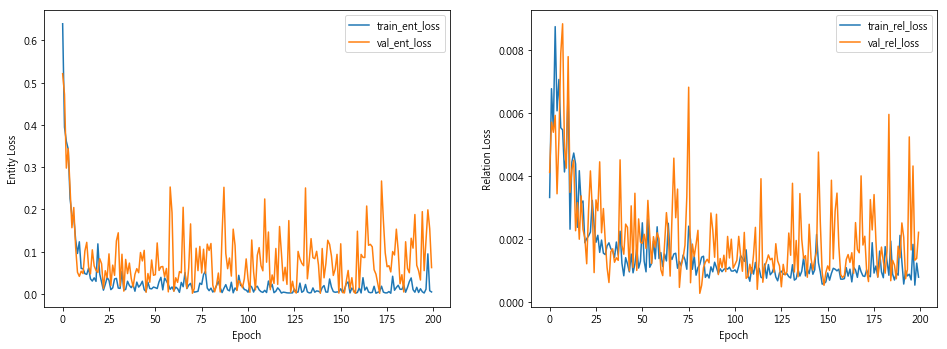

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# # Check predictions after training
# with torch.no_grad():
#     r_choose = random_choose(input_var)
#     model.eval()
#     ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
#                                        if USE_CUDA else batch_ent, isTrain=True)
    
#     batchsize = input_var[r_choose].size(0)
    
#     ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
#     ent_output = ent_argmax(ent_output, batchsize)
    
#     rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
#     print()
#     print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
#     print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
#     print()
#     print("Entity loss : %.4f" % ent_loss)
#     print("Relation loss : %.4f" % rel_loss)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input, isTrain=False, silent=False):
    tps, fps, tns, fns = 0, 0, 0, 0
    y_ent_true_all, y_ent_pred_all = [], []
    y_rel_true_all, y_rel_pred_all = [], []
    print_every_batch = 5

    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)

            
            if not silent:
                print()    
                print("Entity loss : %.4f" % ent_loss)
                print("Relation loss : %.4f" % rel_loss)
                print()
                print('===========================================')
                
#             elif step%print_every_batch==0:
#                 print()    
#                 print("Entity loss : %.4f" % ent_loss)
#                 print("Relation loss : %.4f" % rel_loss)
#                 print()
#                 print('===========================================')
            else:
                pass

            tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel = \
            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel, silent)
            
            
            
            

            y_ent_true_all.extend(y_true_ent)
            y_ent_pred_all.extend(y_pred_ent)

            y_rel_true_all.extend(y_true_rel)
            y_rel_pred_all.extend(y_pred_rel)
            
            tps += tp
            fps += fp
            tns += tn
            fns += fn
        
        
        print()
        print("Entity detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_ent_true_all, y_ent_pred_all, average='micro', 
                                                  labels=range(len(schema['entity'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("Relation detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_rel_true_all, y_rel_pred_all, average='micro', 
                                              labels=range(len(schema['relation'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("ReferenceEntity+Relation score")
        print("%s \t %s \t %s \t    %s %s %s %s" % ('precision ', 'recall ', 'fbeta_score ', 'tp', 'fp', 'tn', 'fn'))
        p_r_f1 = p_r_fscore(tps, fps, tns, fns)
        print('%.3f \t\t %.3f \t\t %.3f \t\t    %d %d %d %d' % (p_r_f1[0], p_r_f1[1], p_r_f1[2], tps, fps, tns, fns))

            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel, silent):
    
    eval_ent_list_true_l, eval_rel_list_true_l = [], []
    eval_ent_list_pred_l, eval_rel_list_pred_l = [], []
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        if not silent:
            print(word_list)
            print(true_ent)
            print(true_r_list)
            print()
            print('Predict output')
            print(pridict_ent)
            print(pre_r_list)
            print()
            print('True')
            print(eval_ent_list_true)
            print(eval_rel_list_true)
            print('predict')
            print(eval_ent_list_pred)
            print(eval_rel_list_pred)
            print("=====================================")
        
        eval_ent_list_true_l.append(eval_ent_list_true)
        eval_rel_list_true_l.append(eval_rel_list_true)
        eval_ent_list_pred_l.append(eval_ent_list_pred)
        eval_rel_list_pred_l.append(eval_rel_list_pred)
    
    
    e_score, y_true_ent, y_pred_ent = get_scores(eval_ent_list_true_l, eval_ent_list_pred_l, \
                                                 range(len(schema['entity'])),output_y=True)
    r_score, y_true_rel, y_pred_rel = get_scores(eval_rel_list_true_l, eval_rel_list_pred_l, \
                                                 range(len(schema['relation'])),output_y=True)
    
    tp, fp, tn, fn = relation_error_analysis(eval_rel_list_true_l, eval_rel_list_pred_l)
    
    if not silent:
        print('Batch entity score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(e_score)
        print()
        print('Batch relation score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(r_score)
        print()
        print('p_r_fscore')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(p_r_fscore(tp, fp, tn, fn), tp, fp, tn, fn)
        print('===========================================')
    
    return tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = e_pairs
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(tuple(e_pairs_copy))
    
    return eval_rel_list
    
        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB
            

            
def get_scores(true_lists, pred_lists, labels, output_y=False):
    y_true, y_pred = [], []
    for t_list, p_list in zip(true_lists, pred_lists):
        yt, yp = align_yt_yp(t_list, p_list, labels)
        y_true.extend(yt)
        y_pred.extend(yp)
        
    scores = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels)
    return scores, y_true, y_pred if output_y else scores

def align_yt_yp(truths, predictions, labels):
    '''
    Input:
        truths/predictions: list of true and predicted tuples, 
        with the leading entries as the structure and the last entry as the class,
        e.g., [(e1, e2, rel), ...]
        labels: sequence of valid class
    Output:
        yt: list of true class given a structure
        yp: list of predicted class given a structure
    '''
    yt, yp = [], []
    _ID_NONE = len(labels)
    true_dict = { t[:-1]: t[-1] for t in truths }
    for p in predictions:
        yt.append(true_dict.pop(p[:-1], _ID_NONE))
        yp.append(p[-1])
    for target in true_dict.values():
        yt.append(target)
        yp.append(_ID_NONE)
    return yt, yp



def is_neg_triple(t):
    return np.imag(t[-1]) > 0

def negate_triple(t):
    # Mark negative triples with imaginary relation id
    return (t[0], t[1], np.real(t[-1]).item() + 1j)

def posit_triple(t):
    return (t[0], t[1], np.real(t[-1]).item())

def has_edge(base_ptrs, rel, e):
    '''
    Assume a relation exist between an entity pair, 
    if all the tokens in the base entity point to those in entity e.
    '''
    tok_has_ptr_to_e = [tok_ptrs[rel].ge(e[0]).dot(tok_ptrs[rel].le(e[1])).item() > 0 
                        for tok_ptrs in base_ptrs]
    return len(tok_has_ptr_to_e) > 0 and all(tok_has_ptr_to_e)


def relation_error_analysis(true_rel_lists, rel_lists):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i, r_list in enumerate(rel_lists):
        true_pos = len([t for t in r_list if t in true_rel_lists[i]])
        all_true = len([t for t in true_rel_lists[i] if not is_neg_triple(t)])
        all_pos = len(r_list)
        tp += true_pos
        fn += all_true - true_pos
        fp += all_pos - true_pos
        tn += len([t for t in true_rel_lists[i] if is_neg_triple(t) and posit_triple(t) not in r_list])
    return tp, fp, tn, fn

def p_r_fscore(tp, fp, tn, fn, beta=1, eps=1e-8):
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r + eps))
    return p, r, f_beta

In [16]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.0505
Relation loss : 0.0015

['而', '這', '瓶', '一', '點', '都', '不', '油', '膩', ',', '塗', '起', '來', '吸', '收', '度', '快', '又', '清', '爽', ',', '卻', '又', '很', '保', '濕', ',', '因', '為', '是', '夏', '天', '擔', '心', '會', '黏', '或', '長', '痘', '痘', ',', '但', '完', '全', '沒', '這', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 

['使', '用', '後', '的', '感', '想', ',', '使', '用', '在', '手', '上', '塗', '抹', '均', '勻', '很', '快', '就', '被', '肌', '膚', '吸', '收', ',', '使', '用', '在', '私', '密', '部', '位', ',', '我', '個', '人', '覺', '得', '可', '能', '要', '長', '期', '使', '用', '已', '即', '使', '用', '很', '多', '才', '會', '有', '美', '白', '的', '效', '果', ',', '在', '夏', '季', '使', '用', '真', '的', '很', '舒', '服', ',', '但', '就', '是', '蠻', '麻', '煩', '的', ',', '其', '他', ',', '就', '還', '好', '啦']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['皮', '膚', '乾', '燥', '狀', '況', '就', '馬', '上', '得', '到', '舒', '緩', ',']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', '', '', '', '', '']

True
[(0, 3, 1), (11, 12, 0)]
[((0, 3, 1), (11, 12, 0), 0)]
predict
[(0, 3, 1)]
[]
['3', '.', '我', '是', '乾', '燥', '肌', '.', '對', '於', '不', '夠', '保', '濕', '的', '產', '品', '不', '是', '擦', '了', '有', '緊', '繃', '感', '難', '推', '勻', '.', '就', '是', '會', '卡', '粉', '抬', '頭', '紋']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', '', '', '

['整', '體', '來', '說', '保', '濕', '度', '還', '可', '以', ',', '但', '推', '薦', '夏', '天', '使', '用', ',', '冬', '天', '可', '能', '不', '夠', '力', ',', '吸', '收', '度', '還', '不', '錯', ',', '但', '我', '白', '天', '用', '了', '這', '瓶', '乳', '液', '之', '後', '變', '的', '很', '容', '易', '出', '油', ',', '所', '以', '我', '都', '晚', '上', '睡', '覺', '時', '才', '用']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['因', '為', '是', '在', '秋', '天', '這', '個', '季', '節', '試', '用', ',', '我', '覺', '得', '控', '油', '力', '稍', '嫌', '不', '足']
['O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(4, 5, 2), (16, 17, 0)]
[]
predict
[(4, 5, 2)]
[]
['原', '本', '肌', '膚', '敏', '感', '泛', '紅', '的', '部', '分', '也', '舒', '緩', '許', '多']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', '

['3', '.', '夏', '天', '的', '太', '陽', '很', '毒', '辣', ',', '有', '一', '次', '沒', '機', '會', '補', '防', '曬', '所', '以', '有', '點', '曬', '傷', ',', '到', '了', '晚', '上', '臉', '就', '紅', '紅', '熱', '熱', '的', ',', '在', '噴', '過', '礦', '泉', '噴', '霧', '後', ',', '就', '使', '用', '這', '精', '華', '油', '與', '保', '溼', '精', '華', '液', '1', ':', '1', '的', '比', '例', ',', '隔', '天', '紅', '臉', '跟', '臉', '熱', '熱', '的', '情', '形', '完', '全', '看', '不', '見', ',', '可', '見', '這', '瓶', '精', '華', '油', '修', '復', '力', '很', '好']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '

['使', '用', '期', '間', '臉', '部', '斑', '點', '沒', '增', '加', ',', '這', '款', '美', '白', '產', '品', '在', '黑', '色', '素', '生', '成', '前', '就', '先', '阻', '斷', ',', '並', '同', '時', '修', '護', '肌', '膚', '細', '胞', ',', '比', '較', '偏', '向', '預', '防', '性', '的', '功', '能', ',', '在', '冬', '天', '先', '把', '肌', '膚', '養', '好', ',', '減', '少', '黑', '色', '素', '等', '不', '良', '因', '子', '增', '生', ',', '只', '要', '防', '曬', '同', '時', '做', '好', ',', '春', '夏', '就', '能', '減', '少', '色', '素', '斑', '點', '的', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '',

['本', '身', '是', '乾', '性', '肌', ',', '些', '微', '泛', '紅', ',', '後', '續', '仍', '要', '加', '上', '保', '濕', '產', '品']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(3, 5, 1)]
[]
predict
[(3, 5, 1)]
[]
['使', '用', '這', '粉', '餅', '的', '感', '覺', '整', '體', '還', '不', '錯', '沒', '有', '什', '麼', '特', '別', '味', '道', '對', '於', '服', '貼', '度', '還', '不', '錯', '遮', '瑕', '度', '還', '好', '持', '久', '度', '也', '是', '尚', '可', '但', '對', '於', '保', '濕', '上', '也', '不', '錯', '擦', '上', '去', '不', '會', '很', '乾', '也', '不', '會', '很', '油', '還', '滿', '舒', '服', '的', '很', '適', '合', '油', '性', '肌', '使', '用', '也', '不', '會', '長', '痘'

['看', '了', '一', '下', '商', '品', '說', '明', ',', '了', '解', '這', '項', '產', '品', '主', '要', '訴', '求', '就', '是', '保', '濕', ',', '連', '夏', '天', '在', '冷', '氣', '房', '會', '造', '成', '的', '乾', '燥', '肌', '膚', '也', '很', '適', '合', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', [], [], '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', 

['看', '到', '特', '級', '保', '溼', '+', '凝', '凍', '二', '字', ',', '就', '覺', '得', '夏', '天', '一', '定', '要', '購', '入', '了', '吧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '']

True
[(15, 16, 2)]
[]
predict
[(4, 5, 0), (15, 16, 2)]
[((4, 5, 0), (15, 16, 2), 1)]
['對', '於', '冬', '天', '肌', '膚', '偏', '乾', '的', '我', '似', '乎', '不', '夠', '保', '濕', ',', '需', '要', '再', '加', '強', '前', '後', '的', '化', '妝', '水', '&', '乳', '液', '使', '用']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I

['不', '過', '夏', '天', '嘛', '.', '想', '清', '爽', '一', '點', '的', '人', ',', '它', '的', '保', '濕', '度', '還', '是', '夠', '的']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '']

Predict output
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], [], '', '', '', '']

True
[(2, 3, 2), (16, 18, 0)]
[((2, 3, 2), (16, 18, 0), 1)]
predict
[(2, 3, 2), (16, 18, 0)]
[]
['冬', '天', '用', '它', '應', '該', '很', '適', '合', ',', '很', '保', '濕', '完', '全', '不', '乾', '燥']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O',

['整', '體', '來', '說', ',', '它', '是', '款', '基', '本', '保', '溼', '度', '夠', '的', '乳', '液', ',', '只', '是', '在', '夏', '天', '擦', '這', '麼', '油', '的', '乳', '液', ',', '會', '特', '別', '容']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '']

True
[(10, 11, 0), (21, 22, 2)]
[]
predict
[(10, 11, 0), (21, 22, 2)]
[((10, 11, 

['敷', '了', '幾', '天', '痘', '痘', '就', '消', '了', ',', '雖', '然', '她', '說', '味', '道', '怪', '怪', '的', ',', '但', '還', '是', '敷', '得', '很', '開', '心', ',', '尤', '其', '現', '在', '冬', '季', '天', '冷', '又', '乾', '燥', ',', '拿', '來', '敷', '臉', '真', '的', '很', '不', '錯', ',', '皮', '膚', '也', '比', '之', '前', '更', '水', '潤', '白', '析', ',', '毛', '孔', '也', '變', '小', '了', '些', ',', '緊', '緻', '度', '也', '有', '提', '升', ',', '保', '養', '做', '得', '好', '上', '妝', '也', '沒', '煩', '腦', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['也', '可', '以', '舒', '緩', '及', '消', '除', '眼', '部', '浮', '腫', ',', '冬', '天', '使', '用', '還', '有', '提', '神', '的', '效', '果', '^', '^']
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '']

True
[(3, 4, 0), (13, 14, 2)]
[((3, 4, 0), (13, 14, 2), 1)]
predict
[(3, 4, 0), (13, 14, 2)]
[((3, 4, 0), (13, 14, 2), 1)]
['但', '保', '濕', '效', '果', '還', '算', '不', '錯', ',', '抹', '完', '再', '塗', '防', '曬', '也', '不', '覺', '得', '太', '油', '膩

In [17]:
# load test set

input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.866 		 0.939 		 0.901 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.701 		 0.629 		 0.663 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.701 		 0.629 		 0.663 		    61 26 0 36


In [19]:
def continue_train():
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
    criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
    
    n_iters = 150
    print_every = 12

    train_entloss_l = []
    val_entloss_l = []
    train_relloss_l = []
    val_relloss_l = []

    loss = 0
    
    for epoch in tqdm(range(n_iters)):  
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            batch_ent = batch_ent.view(batchsize*MAX_LEN)
            batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)

            entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
            relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
            loss = entloss+relloss

            loss.backward()
            optimizer.step()


        train_entloss_l.append(entloss.cpu())
        train_relloss_l.append(relloss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))

        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
            val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))

        val_entloss_l.append(val_entloss.cpu())
        val_relloss_l.append(val_relloss.cpu())

        
        
#         evaluate_data(loader, raw_input, isTrain=True, silent=True)
        
        print()
        print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
              % (epoch+1, entloss, relloss, loss))
        print("      %s  | val ent loss %.4f | val rel loss %.4f"
              % (" "*len(str(epoch+1)), val_entloss, val_relloss))
        

In [20]:
# continue_train()

In [21]:
# evaluate_data(dev_loader, raw_input_dev, isTrain=True)

In [22]:
# evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)

In [23]:
evaluate_data(dev_loader, raw_input_dev, isTrain=False)


Entity loss : 0.0723
Relation loss : 0.0015

['怕', '油', '肌', '膚', '可', '酌', '量', '減', '少', '使', '用', '2', '~', '3', '滴', '調', '整', '用', '量', ',', '再', '以', '精', '華', '液', '與', '乳', '霜', '加', '強', '保', '養']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(1, 3, 1)]
[]
predict
[(1, 3, 1)]
[]
['尤', '其', '已', '經', '快', '要', '夏', '天', '了', ',', '基', '本', '保', '養', '更', '是', '不', '能', '輕', '忽']
['O', 'O', 'O', 'O', '

['敷', '完', '後', '眼', '周', '的', '肌', '膚', '很', '滋', '潤', ',', '的', '確', '有', '保', '濕', '的', '效', '果', ',', '隔', '天', '上', '妝', '也', '很', '著', '妝', ',', '是', '項', '很', '不', '錯', '的', '產', '品', ';', '但', '冬', '天', '使', '用', '可', '能', '會', '有', '點', '冷', 'X', 'D', ',', '因', '現', '在', '的', '天', '氣', '就', '很', '冰', '涼', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['我', '是', '混', '合', '肌', ',', '兩', '頰', '稍', '乾', ',', '那', '部', '分', '若', '沒', '加', '強', '保', '濕', ',', '直', '接', '使', '用', '這', '瓶', '會', '有', '點', '乾', '燥', '的', '感', '覺']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1)]
[]
['使', '用', '後', '的', '感', '想', ',', '使', '用', '在', '手', '上', '塗', '抹', '均', '勻', '很', '快', '就', '被',

['剛', '剛', '好', '自', '己', '是', '乾', '性', '肌', '膚', ',', '所', '以', '來', '試', '用', '粉', '底', '的', '保', '濕', '效', '果', '就', '會', '知', '道', '效', '果', '好', '不', '好']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '']

True
[(6, 9, 1), (19, 20, 0)]
[]
predict
[(6, 9, 1), (19, 20, 0)]
[]
['真', '期', '待', '夏', '天', '來', '使', '用', '這', '款', '吸', '收', '快', '味', '道', '淡', '雅', '的', '美', '白', '+', '保', '濕

['冬', '天', '風', '總', '是', '特', '別', '大', ',', '如', '果', '沒', '有', '做', '好', '保', '養', ',', '會', '感', '覺', '臉', '很', '緊', '繃', ',', '乾', '澀', '乾', '澀', '的', ',', '而', '在', '這', '種', '天', '氣', '下', ',', '使', '用', '這', '款', '乳', '液', '後', ',', '明', '顯', '覺', '得', '臉', '變', '的', '水', '潤', '、', '很', '保', '溼', ',', '對', '於', '偏', '油', '性', '膚', '質', '的', '我', '來', '說', ',', '這', '款', '乳', '液', '正', '是', '我', '需', '要', '的', '呢']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['夏', '天', '的', '白', '天', '擦', '這', '瓶', ',', '就', '很', '棒', ',', '剛', '剛', '好', '的', '保', '溼', ',', '又', '不', '會', '亂', '出', '油']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '']

True
[(0, 1, 2), (17, 18, 0)]
[((0, 1, 2), (17, 18, 0), 1)]
predict
[(0, 1, 2), (17, 18, 0)]
[((0, 1, 2), (17, 18, 0), 1)]
['夏', '天', '用', '太', '黏', '膩', '~', '冬', '天', '的', '話', '會', '不', '夠', '保', '濕', '~', '我', '會', '放', '在', '秋', '天

['使', '用', '這', '粉', '餅', '的', '感', '覺', '整', '體', '還', '不', '錯', '沒', '有', '什', '麼', '特', '別', '味', '道', '對', '於', '服', '貼', '度', '還', '不', '錯', '遮', '瑕', '度', '還', '好', '持', '久', '度', '也', '是', '尚', '可', '但', '對', '於', '保', '濕', '上', '也', '不', '錯', '擦', '上', '去', '不', '會', '很', '乾', '也', '不', '會', '很', '油', '還', '滿', '舒', '服', '的', '很', '適', '合', '油', '性', '肌', '使', '用', '也', '不', '會', '長', '痘', '痘', '擦', '上', '去', '感', '覺', '很', '自', '然', '透', '氣', '度', '也', '不', '錯']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ''

['本', '身', '是', '乾', '性', '肌', ',', '些', '微', '泛', '紅', ',', '後', '續', '仍', '要', '加', '上', '保', '濕', '產', '品']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(3, 5, 1)]
[]
predict
[(3, 5, 1)]
[]
['這', '款', '保', '濕', '化', '妝', '水', '很', '天', '然', ',', '目', '前', '季', '節', '正', '在', '轉', '換', ',', '我', '的', '皮', '膚', '秋', '冬', '時', '會', '偏', '乾', ',', '這', '瓶', '化', '妝', '水', '解', '決', '了', '我', '皮', '膚', '乾', '燥', '的', '問', '題', ',', '並', '且', '接', '著', '上', '精', '華', '液', '很', '好', '吸', '收', ',', '有', '時', '我', '會', '濕', '敷', '它', '候', ',', '在', '上', '妝', '會', '很', '服', '貼', '.', '我', '想'

['看', '到', '特', '級', '保', '溼', '+', '凝', '凍', '二', '字', ',', '就', '覺', '得', '夏', '天', '一', '定', '要', '購', '入', '了', '吧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

True
[(15, 16, 2)]
[]
predict
[(4, 5, 0), (15, 16, 2)]
[]
['保', '濕', '度', '在', '夏', '天', '倒', '是', '還', '不', '錯', ',']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-SEAS', 'I-SEAS', 'O', 

['整', '體', '來', '說', '保', '濕', '度', '還', '可', '以', ',', '但', '推', '薦', '夏', '天', '使', '用', ',', '冬', '天', '可', '能', '不', '夠', '力', ',', '吸', '收', '度', '還', '不', '錯', ',', '但', '我', '白', '天', '用', '了', '這', '瓶', '乳', '液', '之', '後', '變', '的', '很', '容', '易', '出', '油', ',', '所', '以', '我', '都', '晚', '上', '睡', '覺', '時', '才', '用']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['使', '用', '此', '產', '品', '1', '週', '左', '右', '後', ',', '老', '化', '肌', '膚', '表', '淺', '紋', '路', ',', '且', '有', '感', '受', '到', '滋', '潤', '乾', '燥', '肌', '膚', ',', '粗', '糙', '肌', '膚', '也', '慢', '慢', '有', '平', '滑', '柔', '嫩', '的', '效', '果', '及', '有', '效', '改', '善', '毛', '孔', '粗', '大', '及', '肌', '膚', '老', '化', '非', '常', '之', '顯', '著', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O

['很', '適', '合', '夏', '天', '使', '用', '的', '精', '華', '液', ',', '可', '以', '保', '濕', '但', '又', '不', '會', '過', '於', '油', '膩']
['O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '']

True
[(3, 4, 2), (14, 15, 0)]
[((3, 4, 2), (14, 15, 0), 1)]
predict
[(3, 4, 2), (14, 15, 0)]
[((3, 4, 2), (14, 15, 0), 1)]
['◎', '洋', '甘', '菊', '精', '華', ':', '舒', '緩', '肌', '膚', '敏', '感', '不', '適']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT

['因', '為', '本', '身', '是', '敏', '感', '肌', '的', '關', '係', ',', '使', '用', '美', '白', '類', '的', '產', '品', '特', '別', '注', '意', '小', '心', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(5, 7, 1)]
[]
predict
[(5, 7, 1)]
[]
['其', '實', '產', '品', '本', '身', '的', '保', '濕', '度', '很', '優', ',', '很', '適', '合', '熱', '到', '不', '行', '的', '夏', '天', '使', '用', ',', '但', '我', '的', '皮', '膚', '比', '較', '乾', ',', '還', '是', '必', '須', '上', '一', '點', '霜', '狀', '的', '保', '濕', '產', '品', '補', '強', '一', '下', '=', ')']
['O', 'O

['夏', '天', '混', '合', '肌', '的', '保', '養', '更', '須', '注', '意', ',', '這', '瓶', '乳', '液', '也', '許', '中', '乾', '性', '肌', '膚', '使', '用', '起', '來', '較', '能', '體', '驗', '成', '效', ',']
['B-SEAS', 'I-SEAS', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 2), (2, 4, 1)]
[]
predict
[(0, 1, 2), (2, 4, 1), (20, 23, 1)]
[]
['所', '以', '每', '次', '擦',

['結', '合', '多', '糖', '體', '、', '甘', '菊', '、', '山', '楂', '、', '牡', '丹', '等', '天', '然', '植', '物', '活', '性', '精', '華', ',', '還', '有', '維', '他', '命', 'B', '5', '、', '白', '藜', '蘆', '醇', '等', '的', '專', '利', '鎮', '定', '複', '合', '成', '分', ',', '對', '於', '敏', '感', '肌', '膚', '的', '泛', '紅', '症', '狀', ',', '可', '以', '立', '即', '鎮', '定', '舒', '緩', ',', '讓', '膚', '色', '呈', '現', '均', '勻', '樣', ',', '是', '一', '款', '很', '有', '修', '護', '防', '禦', '的', '精', '華', '液', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '

In [24]:
evaluate_data(test_loader, raw_input_test, isTrain=False, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.867 		 0.934 		 0.900 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.831 		 0.653 		 0.731 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.831 		 0.653 		 0.731 		    64 13 0 34


In [27]:
torch.save(model.state_dict(), 'relation_extraction_mr1_731.pkl')

In [26]:
len(input_var), len(input_dev), len(input_test)

(788, 101, 200)